# Task 2

---

## Predictive modeling of customer bookings

This Jupyter notebook includes some code to get you started with this predictive modeling task. We will use various packages for data manipulation, feature engineering and machine learning.

### Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix , classification_report , accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

In [3]:
df = pd.read_csv("data/customer_booking.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [5]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [6]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [7]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5], dtype=int64)

In [8]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


The `.describe()` method gives us a summary of descriptive statistics over the entire dataset (only works for numeric columns). This gives us a quick overview of a few things such as the mean, min, max and overall distribution of each column.

From this point, you should continue exploring the dataset with some visualisations and other metrics that you think may be useful. Then, you should prepare your dataset for predictive modelling. Finally, you should train your machine learning model, evaluate it with performance metrics and output visualisations for the contributing variables. All of this analysis should be summarised in your single slide.

## Data Preprocessing

In [9]:
df.isnull().sum()

num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               0
route                    0
booking_origin           0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
booking_complete         0
dtype: int64

In [10]:
categorical_df = df.select_dtypes(include="object")
numerical_df = df.select_dtypes(exclude="object")

In [11]:
numerical_df.head()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,262,19,7,6,1,0,0,5.52,0
1,1,112,20,3,6,0,0,0,5.52,0
2,2,243,22,17,3,1,1,0,5.52,0
3,1,96,31,4,6,0,0,1,5.52,0
4,2,68,22,15,3,1,0,1,5.52,0


In [12]:
categorical_df.head()

,sales_channel,trip_type,route,booking_origin
0,Internet,RoundTrip,AKLDEL,New Zealand
1,Internet,RoundTrip,AKLDEL,New Zealand
2,Internet,RoundTrip,AKLDEL,India
3,Internet,RoundTrip,AKLDEL,New Zealand
4,Internet,RoundTrip,AKLDEL,India


In [13]:
categorical_df.describe()

,sales_channel,trip_type,route,booking_origin
count,50000,50000,50000,50000
unique,2,3,799,104
top,Internet,RoundTrip,AKLKUL,Australia
freq,44382,49497,2680,17872


In [14]:
for column in categorical_df:
    print(categorical_df[column].value_counts())
    print("\n")

Internet    44382
Mobile       5618
Name: sales_channel, dtype: int64


RoundTrip     49497
OneWay          387
CircleTrip      116
Name: trip_type, dtype: int64


AKLKUL    2680
PENTPE     924
MELSGN     842
ICNSIN     801
DMKKIX     744
          ... 
LBUTPE       1
CXRMEL       1
DELKBR       1
KOSSYD       1
MRUXIY       1
Name: route, Length: 799, dtype: int64


Australia               17872
Malaysia                 7174
South Korea              4559
Japan                    3885
China                    3387
                        ...  
Panama                      1
Tonga                       1
Tanzania                    1
Bulgaria                    1
Svalbard & Jan Mayen        1
Name: booking_origin, Length: 104, dtype: int64




In [15]:
categorical_df=pd.get_dummies(categorical_df,drop_first=True)

In [16]:
categorical_df.head()

,sales_channel_Mobile,trip_type_OneWay,trip_type_RoundTrip,route_AKLHGH,route_AKLHND,route_AKLICN,route_AKLKIX,route_AKLKTM,route_AKLKUL,route_AKLMRU,...,booking_origin_Timor-Leste,booking_origin_Tonga,booking_origin_Tunisia,booking_origin_Turkey,booking_origin_Ukraine,booking_origin_United Arab Emirates,booking_origin_United Kingdom,booking_origin_United States,booking_origin_Vanuatu,booking_origin_Vietnam
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
numerical_df.head()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,262,19,7,6,1,0,0,5.52,0
1,1,112,20,3,6,0,0,0,5.52,0
2,2,243,22,17,3,1,1,0,5.52,0
3,1,96,31,4,6,0,0,1,5.52,0
4,2,68,22,15,3,1,0,1,5.52,0


## Outlier detection

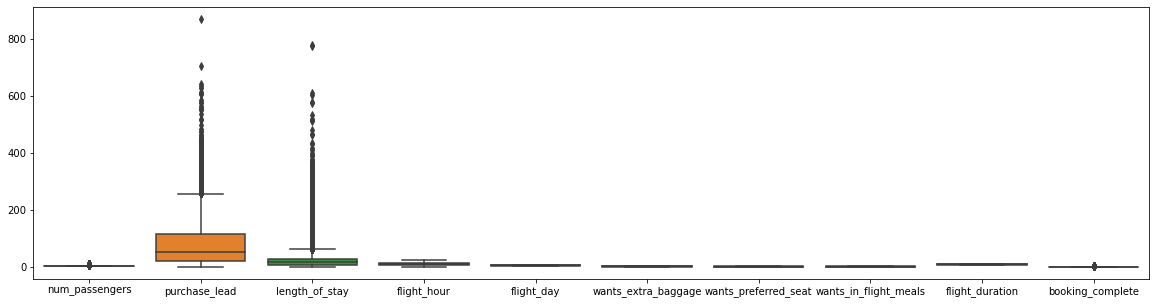

In [18]:
plt.figure(figsize=(20,5))
sns.boxplot(data = numerical_df)
plt.show()

In [19]:
numerical_df.columns

Index(['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour',
       'flight_day', 'wants_extra_baggage', 'wants_preferred_seat',
       'wants_in_flight_meals', 'flight_duration', 'booking_complete'],
      dtype='object')

In [20]:
column_list = ['purchase_lead', 'length_of_stay']
for feature in column_list:
    Q1= numerical_df[feature].quantile(0.25)
    Q3 =numerical_df[feature].quantile(0.75)
    IQR = Q3 - Q1
    
    
    lower_limit = Q1 - 1.5 * IQR
    
    upper_limit = Q3 + 1.5 * IQR
  
    
    median = numerical_df[feature].median()
    
    numerical_df[feature] = np.where(numerical_df[feature]< lower_limit, median,numerical_df[feature])
    numerical_df[feature] = np.where(numerical_df[feature]> upper_limit, median,numerical_df[feature])

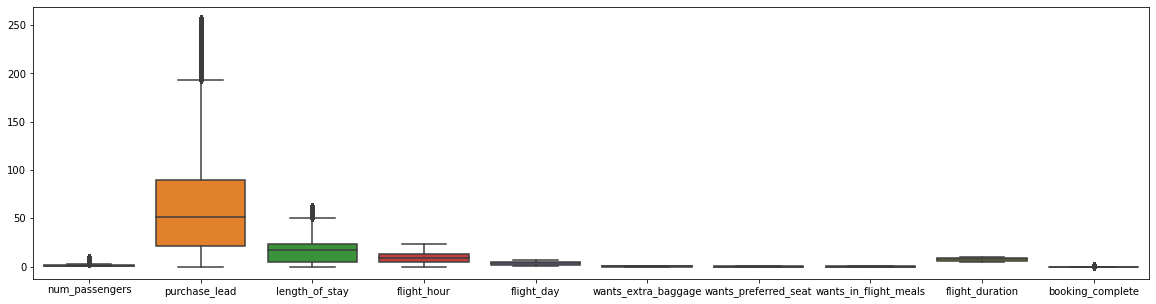

In [21]:
plt.figure(figsize=(20,5))
sns.boxplot(data = numerical_df)
plt.show()

## Concatinating both Dataframes

In [22]:
df = pd.concat([categorical_df,numerical_df], axis =1)

In [23]:
df.head()

,sales_channel_Mobile,trip_type_OneWay,trip_type_RoundTrip,route_AKLHGH,route_AKLHND,route_AKLICN,route_AKLKIX,route_AKLKTM,route_AKLKUL,route_AKLMRU,...,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,0,0,1,0,0,0,0,0,0,0,...,2,51.0,19.0,7,6,1,0,0,5.52,0
1,0,0,1,0,0,0,0,0,0,0,...,1,112.0,20.0,3,6,0,0,0,5.52,0
2,0,0,1,0,0,0,0,0,0,0,...,2,243.0,22.0,17,3,1,1,0,5.52,0
3,0,0,1,0,0,0,0,0,0,0,...,1,96.0,31.0,4,6,0,0,1,5.52,0
4,0,0,1,0,0,0,0,0,0,0,...,2,68.0,22.0,15,3,1,0,1,5.52,0


## Checking for Duplicate Values

In [28]:
df.duplicated().sum()

731

In [29]:
df = df.drop_duplicates()
df.duplicated().sum()

0

## Splitting Data for Training

In [30]:
# Separating dependent and independent variables
X = df.drop(["booking_complete"] , axis=1)
y = df["booking_complete"]

In [31]:
y.value_counts()

0    41879
1     7390
Name: booking_complete, dtype: int64

## Over sampling the Data to remove Data Imbalance

In [32]:
smote = SMOTE()
x_smote, y_smote = smote.fit_resample(X, y)
print(x_smote.shape)
print(y_smote.shape)

(83758, 913)
(83758,)


In [36]:
y_smote.value_counts()

0    41879
1    41879
Name: booking_complete, dtype: int64

In [37]:
x_smote.head()

,sales_channel_Mobile,trip_type_OneWay,trip_type_RoundTrip,route_AKLHGH,route_AKLHND,route_AKLICN,route_AKLKIX,route_AKLKTM,route_AKLKUL,route_AKLMRU,...,booking_origin_Vietnam,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration
0,0,0,1,0,0,0,0,0,0,0,...,0,2,51.0,19.0,7,6,1,0,0,5.52
1,0,0,1,0,0,0,0,0,0,0,...,0,1,112.0,20.0,3,6,0,0,0,5.52
2,0,0,1,0,0,0,0,0,0,0,...,0,2,243.0,22.0,17,3,1,1,0,5.52
3,0,0,1,0,0,0,0,0,0,0,...,0,1,96.0,31.0,4,6,0,0,1,5.52
4,0,0,1,0,0,0,0,0,0,0,...,0,2,68.0,22.0,15,3,1,0,1,5.52


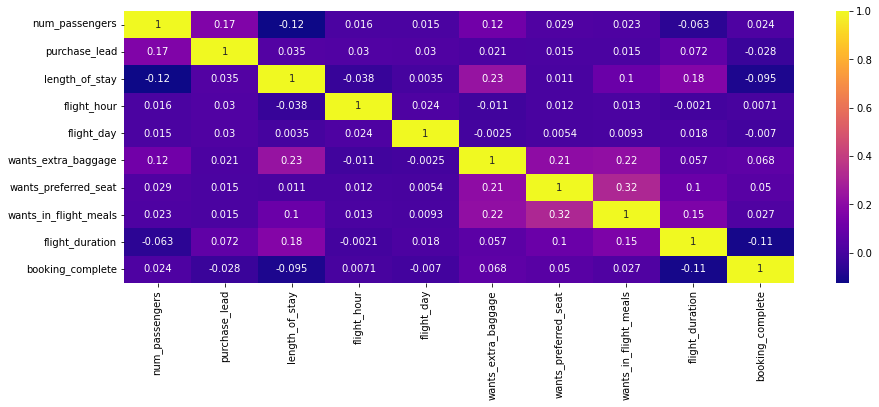

In [38]:
plt.figure(figsize=(15,5))
sns.heatmap(numerical_df.corr() , annot=True, cmap="plasma")
plt.show()

In [39]:
x_train, x_test, y_train, y_test = train_test_split(x_smote,y_smote, test_size=0.20,random_state=42)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(67006, 913)
(16752, 913)
(67006,)
(16752,)


## Building Model

In [40]:
# using random forest classifier
model = RandomForestClassifier()
model.fit(x_train, y_train)

RandomForestClassifier()

In [41]:
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)

In [42]:
print("Accuracy for Train Data")
print(accuracy_score(y_train, y_pred_train))
print("Accuracy for Test Data")
print(accuracy_score(y_test, y_pred_test))

Accuracy for Train Data
0.9998806077067726
Accuracy for Test Data
0.8987583572110793


In [43]:
print("Confusion Matrix for Train Data")
print(confusion_matrix(y_train, y_pred_train))
print("Confusion Matrix for Test Data")
print(confusion_matrix(y_test, y_pred_test))

Confusion Matrix for Train Data
[[33500     5]
 [    3 33498]]
Confusion Matrix for Test Data
[[7686  688]
 [1008 7370]]


In [44]:
print("Classification Report for Train Data")
print(classification_report(y_train, y_pred_train))
print("Classification Report for Test Data")
print(classification_report(y_test, y_pred_test))

Classification Report for Train Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     33505
           1       1.00      1.00      1.00     33501

    accuracy                           1.00     67006
   macro avg       1.00      1.00      1.00     67006
weighted avg       1.00      1.00      1.00     67006

Classification Report for Test Data
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      8374
           1       0.91      0.88      0.90      8378

    accuracy                           0.90     16752
   macro avg       0.90      0.90      0.90     16752
weighted avg       0.90      0.90      0.90     16752



In [45]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

## Hyperparameter Tuning

In [46]:
clf = RandomForestClassifier()

In [47]:
param_grid = {'n_estimators': [50, 100, 200, 250, 300],
              'min_samples_split': [2, 3, 4],
              'min_samples_leaf': [1, 2, 3]}

In [48]:
grid_search = HalvingGridSearchCV(clf, param_grid, cv=5)

In [49]:
grid_search.fit(x_train, y_train)

HalvingGridSearchCV(estimator=RandomForestClassifier(),
                    param_grid={'min_samples_leaf': [1, 2, 3],
                                'min_samples_split': [2, 3, 4],
                                'n_estimators': [50, 100, 200, 250, 300]})

In [50]:
best_params = grid_search.best_params_

In [51]:
print("Best parameters: ", grid_search.best_params_)
print("Best f1 score: ", grid_search.best_score_)

Best parameters:  {'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 300}
Best f1 score:  0.8921117795531265


In [52]:
final_model = RandomForestClassifier(**grid_search.best_params_)

In [53]:
final_model.fit(x_train, y_train)

RandomForestClassifier(min_samples_split=3, n_estimators=300)

## Feature Importance

In [54]:
feature_importances = final_model.feature_importances_

for feature, importance in zip(df.columns, feature_importances):
    print("Feature: ", feature, "\nImportance: ", importance)

Feature:  sales_channel_Mobile 
Importance:  0.027076762380013553
Feature:  trip_type_OneWay 
Importance:  0.0016635901776237351
Feature:  trip_type_RoundTrip 
Importance:  0.0007835150090733372
Feature:  route_AKLHGH 
Importance:  6.131783586654774e-06
Feature:  route_AKLHND 
Importance:  9.760925289320676e-06
Feature:  route_AKLICN 
Importance:  0.00051485016703028
Feature:  route_AKLKIX 
Importance:  3.663837915153925e-05
Feature:  route_AKLKTM 
Importance:  4.186902121991599e-05
Feature:  route_AKLKUL 
Importance:  0.005768947367731643
Feature:  route_AKLMRU 
Importance:  3.092854055441989e-05
Feature:  route_AKLPEK 
Importance:  5.2266284676050525e-05
Feature:  route_AKLPVG 
Importance:  1.736810643342701e-05
Feature:  route_AKLTPE 
Importance:  0.00023929550066124406
Feature:  route_AORICN 
Importance:  0.00015554927211111744
Feature:  route_AORKIX 
Importance:  0.00012072660867753692
Feature:  route_AORKTM 
Importance:  0.0002001557771915275
Feature:  route_AORMEL 
Importance:  

Importance:  1.9635431340544745e-05
Feature:  route_SDKSYD 
Importance:  7.873479808431654e-05
Feature:  route_SDKTPE 
Importance:  2.6651518697418705e-05
Feature:  route_SGNSYD 
Importance:  0.001970835791510299
Feature:  route_SGNXIY 
Importance:  1.1169825152188239e-05
Feature:  route_SINSYD 
Importance:  0.00012666585548673045
Feature:  route_SINTPE 
Importance:  0.00021321885798491192
Feature:  route_SINWUH 
Importance:  0.0001467200571920498
Feature:  route_SINXIY 
Importance:  0.00012321278306903812
Feature:  route_SRGTPE 
Importance:  5.923203333256862e-05
Feature:  route_SUBSYD 
Importance:  5.7899505095240856e-05
Feature:  route_SUBTPE 
Importance:  0.00015495739454688488
Feature:  route_SUBWUH 
Importance:  4.818514707705881e-06
Feature:  route_SUBXIY 
Importance:  6.34307102704762e-05
Feature:  route_SYDSZX 
Importance:  2.5290387069905116e-05
Feature:  route_SYDTPE 
Importance:  0.0010807717209333823
Feature:  route_SYDTRZ 
Importance:  0.0003558627763428472
Feature:  rout

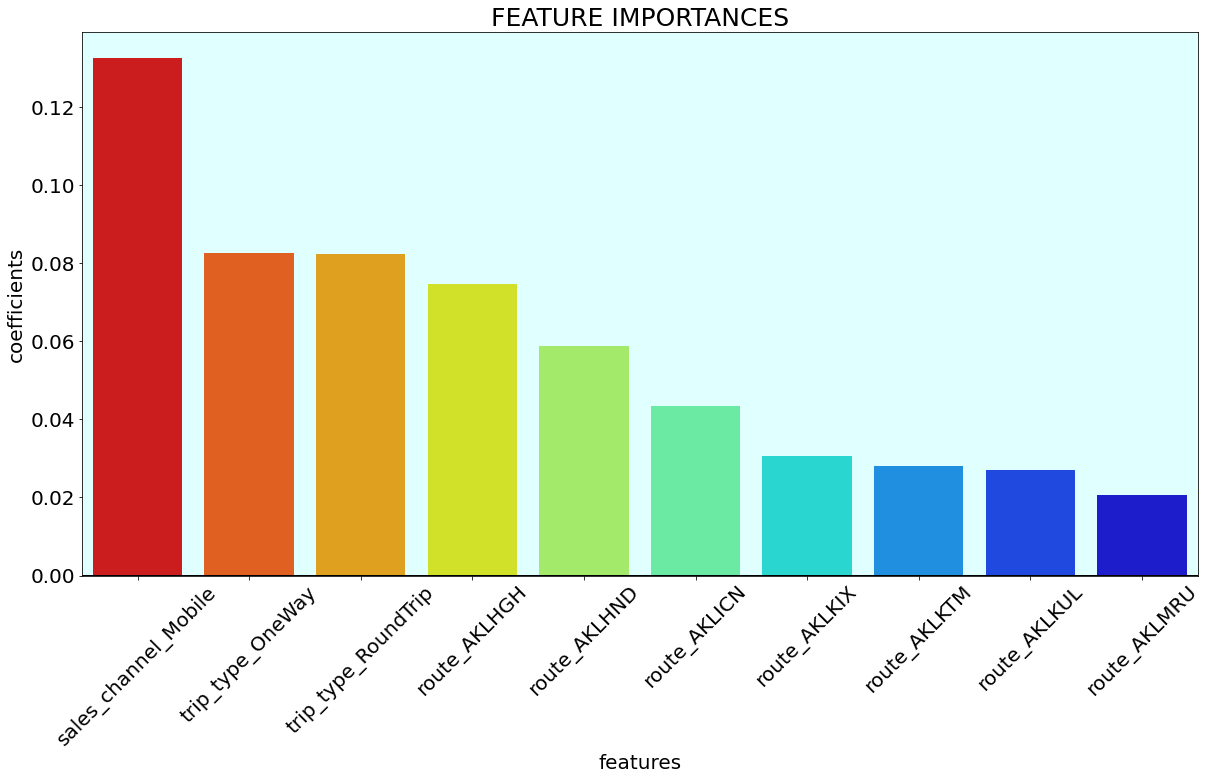

In [82]:
plt.figure(figsize=(20,10))
coef = pd.DataFrame(np.sort(final_model.feature_importances_)[::-1])
coef["feat"] = x_train.columns
coef = coef[:10]
ax1 = sns.barplot(data = coef, x = coef["feat"], y = coef[0],palette="jet_r", linewidth=2)
ax1.set_facecolor("lightcyan")
ax1.axhline(0,color="k",linewidth=2)
plt.ylabel("coefficients", fontsize=20)
plt.xlabel("features", fontsize=20)
plt.xticks(rotation=45, fontsize=20)
plt.yticks(fontsize=20)
plt.title('FEATURE IMPORTANCES', fontsize=25)
plt.savefig('features.png', bbox_inches='tight')
plt.show()

In [75]:
y_pred = final_model.predict(x_test)

In [76]:
y_pred_train = final_model.predict(x_train)
y_pred_test = final_model.predict(x_test)

In [77]:
print("Accuracy for Train Data")
print(accuracy_score(y_train, y_pred_train))
print("Accuracy for Test Data")
print(accuracy_score(y_test, y_pred_test))

Accuracy for Train Data
0.997970331015133
Accuracy for Test Data
0.8996537726838586


In [78]:
print("Confusion Matrix for Train Data")
print(confusion_matrix(y_train, y_pred_train))
print("Confusion Matrix for Test Data")
print(confusion_matrix(y_test, y_pred_test))

Confusion Matrix for Train Data
[[33497     8]
 [  128 33373]]
Confusion Matrix for Test Data
[[7723  651]
 [1030 7348]]


In [79]:
print("Classification Report for Train Data")
print(classification_report(y_train, y_pred_train))
print("Classification Report for Test Data")
print(classification_report(y_test, y_pred_test))

Classification Report for Train Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     33505
           1       1.00      1.00      1.00     33501

    accuracy                           1.00     67006
   macro avg       1.00      1.00      1.00     67006
weighted avg       1.00      1.00      1.00     67006

Classification Report for Test Data
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      8374
           1       0.92      0.88      0.90      8378

    accuracy                           0.90     16752
   macro avg       0.90      0.90      0.90     16752
weighted avg       0.90      0.90      0.90     16752



In [80]:
import pickle

with open('model.pkl', 'wb') as f:
    pickle.dump(final_model, f)